# Libs

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Load data

In [3]:
path_application_train = '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/application_train.csv/application_train.csv'
application_train = pd.read_csv(path_application_train)

In [5]:
temp, test = train_test_split(application_train, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 122), (52277, 122), (46127, 122))

# Logistic Regression

In [6]:
train_logit = copy.deepcopy(train)
valid_logit = copy.deepcopy(valid)
test_logit  = copy.deepcopy(test)

In [7]:
from sklearn import preprocessing
categorical_feats = [
    f for f in application_train.columns if application_train[f].dtype == 'object'
]

for col in categorical_feats:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train_logit[col].values.astype('str')) + list(valid_logit[col].values.astype('str')) + list(test_logit[col].values.astype('str')))
    train_logit[col] = lb.transform(list(train_logit[col].values.astype('str')))
    valid_logit[col] = lb.transform(list(valid_logit[col].values.astype('str')))
    test_logit[col] = lb.transform(list(test_logit[col].values.astype('str')))

In [8]:
train_logit.fillna(-999, inplace = True)
valid_logit.fillna(-999, inplace = True)
test_logit.fillna(-999, inplace = True)

In [9]:
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1), train_logit['TARGET'])

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.0001)

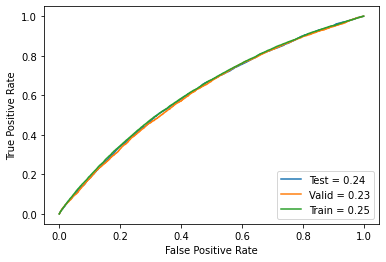

In [10]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 2)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 2)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = log_reg.predict_proba(test_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
pred_valid = log_reg.predict_proba(valid_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
pred_train = log_reg.predict_proba(train_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]

plot_roc_curve(true_y = (test_logit['TARGET'], valid_logit['TARGET'], train_logit['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

# LightGBM

In [11]:
train_lgb = copy.deepcopy(train)
valid_lgb = copy.deepcopy(valid)
test_lgb = copy.deepcopy(test)

In [12]:
categorical_feats = [
    f for f in application_train.columns if application_train[f].dtype == 'object'
]

for col in categorical_feats:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train_lgb[col].values.astype('str')) + list(valid_lgb[col].values.astype('str'))+ list(test_lgb[col].values.astype('str')))
    train_lgb[col] = lb.transform(list(train_lgb[col].values.astype('str')))
    valid_lgb[col] = lb.transform(list(valid_lgb[col].values.astype('str')))
    test_lgb[col] = lb.transform(list(test_lgb[col].values.astype('str')))

In [13]:
lgb_train = lgb.Dataset(data=train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train_lgb.TARGET)
lgb_valid = lgb.Dataset(data=valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid_lgb.TARGET)
lgb_test = lgb.Dataset(data=test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test_lgb.TARGET)

In [14]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model_lgb = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 16927, number of negative: 192180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1471
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080949 -> initscore=-2.429522
[LightGBM] [Info] Start training from score -2.429522
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.731781	valid_1's auc: 0.721609
[100]	training's auc: 0.739036	valid_1's auc: 0.728398
[150]	training's auc: 0.744674	valid_1's auc: 0.733478
[200]	training's auc: 0.748648	valid_1's auc: 0.736868
[250]	training's auc: 0.752367	valid_1's auc: 0.739943
[300]	training's auc: 0.755926	valid_1's auc: 0.742756
[350]	training's auc: 0.758973	valid_1's auc: 

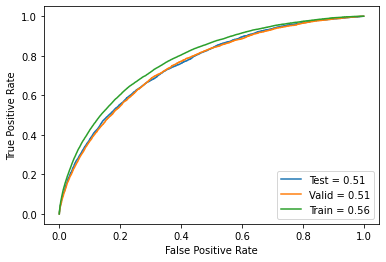

In [15]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 2)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 2)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb.predict(test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = model_lgb.predict(valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = model_lgb.predict(train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test_lgb['TARGET'], valid_lgb['TARGET'], train_lgb['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))